In [18]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [20]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 1e-3
args.batch_size= 256
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [0.9,0.1]
args.save_model = ""
args.dataset = "TRACE"
args.loss_wrapper="rhc_rank"
args.weight = 10.0

In [21]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 5. Framingham
# 6. rott2
# 7. dataDIVAT1
# 8. prostate
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [22]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [23]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([1502, 10])

In [24]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

wrapper = loss_wrapper(args.loss_wrapper)

# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(wrapper(clf_robust,weight=args.weight),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(wrapper(clf_fragile,weight=args.weight),dataloader_train.dataset.tensors)

In [25]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=2052.2329 Time=0.0235
[ 1:   5]: eps=0.00000000 Loss=1954.4063 Time=0.0154
Epoch time: 0.1066, Total time: 0.1066
Evaluating...
[ 1:   1]: eps=0.00000000 Loss=1563.3839 Time=0.0095
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1933.6824 Time=0.0171
[ 2:   5]: eps=0.00000000 Loss=1825.5081 Time=0.0126
Epoch time: 0.0889, Total time: 0.1954
Evaluating...
[ 2:   1]: eps=0.00000000 Loss=1460.2241 Time=0.0056
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=1750.0253 Time=0.0135
[ 3:   5]: eps=0.00000000 Loss=1710.8030 Time=0.0136
Epoch time: 0.0962, Total time: 0.2916
Evaluating...
[ 3:   1]: eps=0.00000000 Loss=1364.4283 Time=0.0050
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=1674.8518 Time=0.0159
[ 4:   5]: eps=0.00000000 Loss=1600.4936 Time=0.0137
Epoch time: 0.0967, Total time: 0.3884
Evaluating...
[ 4:   1]: eps=0.00000000 Loss=1275.7710 Time=0.0077
Epoch 5, learning rate [0.00

In [26]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=2052.2329 Time=0.0210
[ 1:   5]: eps=0.00000000 Loss=1954.4063 Time=0.0170
Epoch time: 0.1202, Total time: 0.1202
Evaluating...
[ 1:   1]: eps=0.00000000 Loss=1563.3839 Time=0.0072
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1933.6824 Time=0.0127
[ 2:   5]: eps=0.00000000 Loss=1825.5081 Time=0.0109
Epoch time: 0.0778, Total time: 0.1980
Evaluating...
[ 2:   1]: eps=0.00000000 Loss=1460.2241 Time=0.0055
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=1750.0253 Time=0.0120
[ 3:   5]: eps=0.00000000 Loss=1710.8030 Time=0.0110
Epoch time: 0.0733, Total time: 0.2713
Evaluating...
[ 3:   1]: eps=0.00000000 Loss=1364.4283 Time=0.0068
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=1674.8518 Time=0.0147
[ 4:   5]: eps=0.00000000 Loss=1600.4936 Time=0.0127
Epoch time: 0.0841, Total time: 0.3554
Evaluating...
[ 4:   1]: eps=0.00000000 Loss=1275.7710 Time=0.0048
Epoch 5, learning rate [0.00

In [27]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

In [28]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 1502 total observations, 736 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_5360\671205530.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


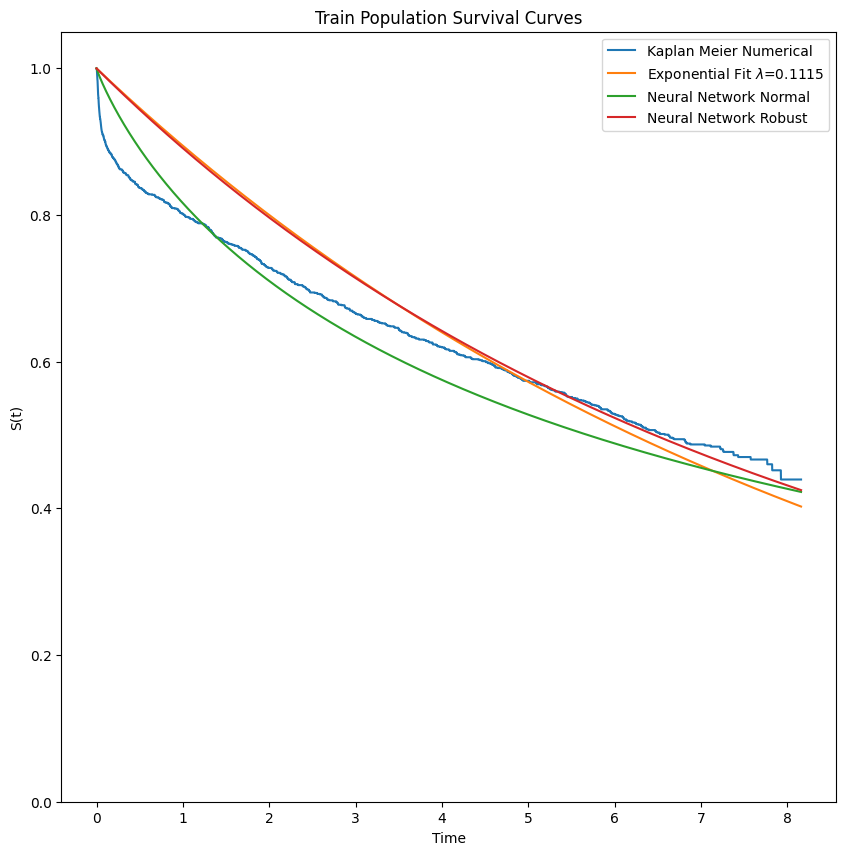

In [29]:
St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

In [30]:
def visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    X,_,_ = dataloader.dataset.tensors


    lambda_robust = clf_robust(X).detach()
    lambda_fragile = clf_fragile(X).detach()

    plot_df = pd.DataFrame({"Lambda Robust": lambda_robust.ravel(), "Lambda Fragile": lambda_fragile.ravel()})

    sns.histplot(data=plot_df, x="Lambda Robust", ax=axes[0], stat="density", legend=False, color="blue")
    axes[0].set_xlim([lambda_fragile.min(), lambda_fragile.quantile(0.99)])
    axes[0].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_robust.mean(),lambda_robust.var()))

    axes[1].set_xlim([lambda_fragile.min(), lambda_fragile.quantile(0.99)])
    axes[1].set_title("$\lambda$ Fragile")
    sns.histplot(data=plot_df, x="Lambda Fragile", ax=axes[1], stat="density", legend=False, color="orange")
    axes[1].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_fragile.mean(),lambda_fragile.var()))

    axes[2].set_xlim([lambda_fragile.min(), lambda_fragile.quantile(0.99)])
    axes[2].set_title("$\lambda$ Overlap")
    sns.histplot(data=plot_df, ax=axes[2], stat="density", legend=True)

    plt.show()

<>:13: DeprecationWarning: invalid escape sequence '\m'
<>:16: DeprecationWarning: invalid escape sequence '\l'


In [31]:
print("Exponential rate parameters: ",1/clf_exp.params_.item())

Exponential rate parameters:  0.11151768589649723


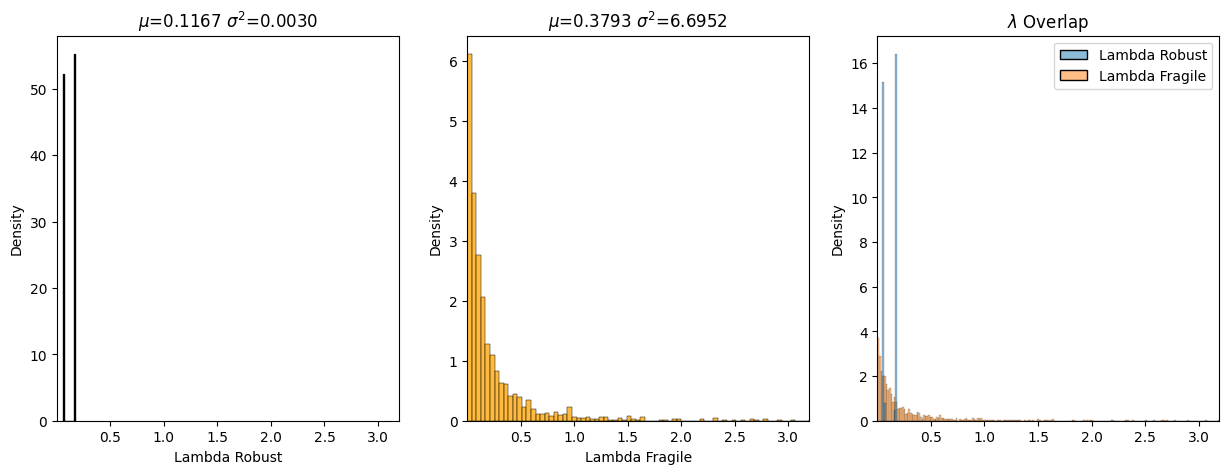

In [32]:
visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader_train)

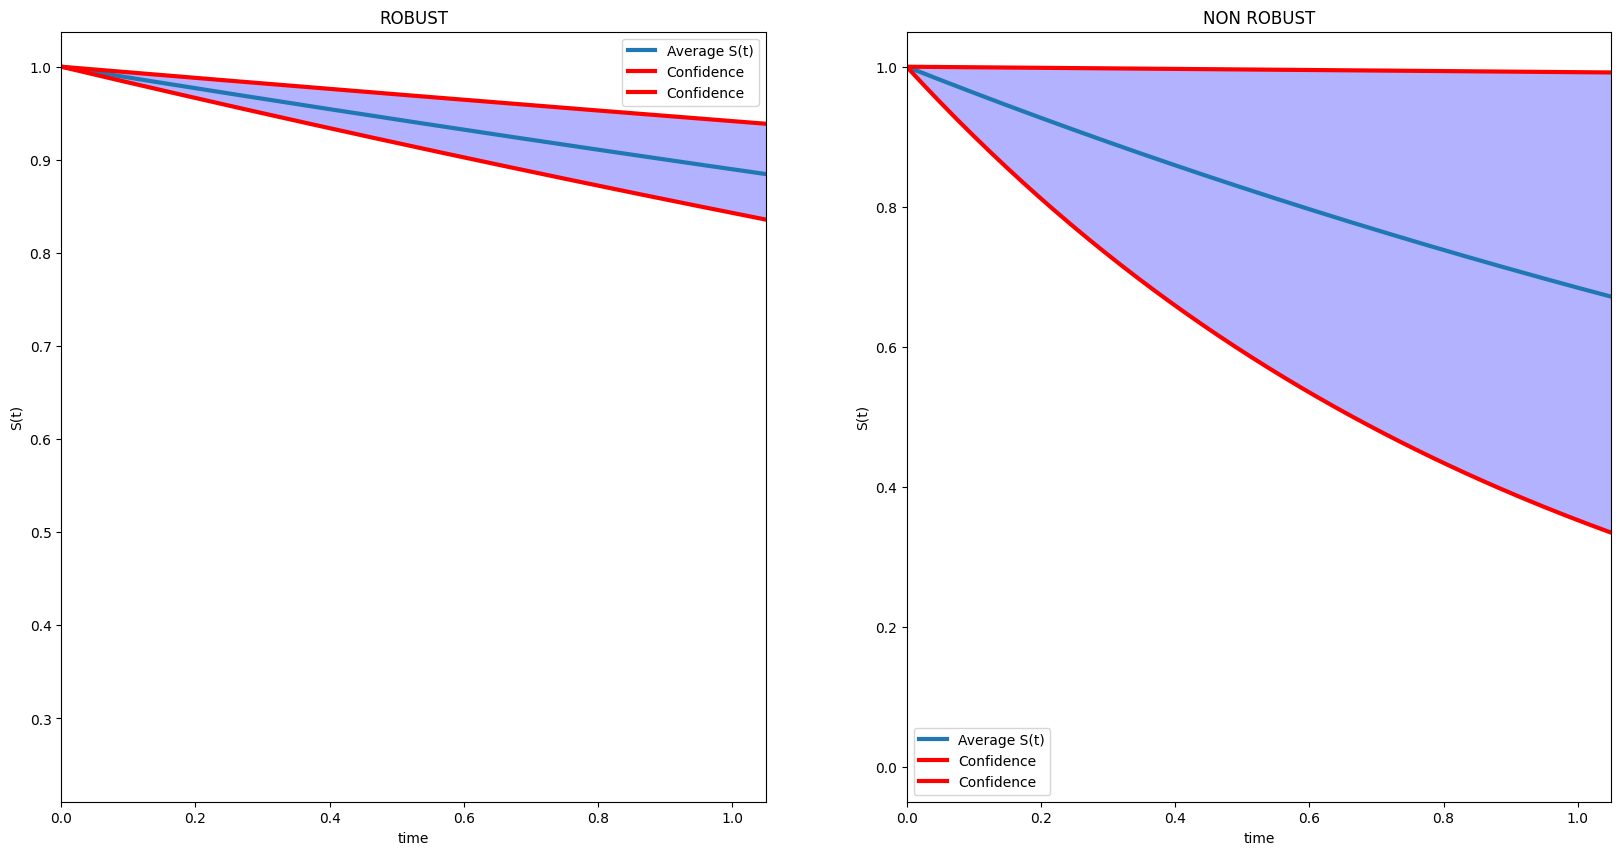

In [33]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_train)

In [ ]:
df_train,df_test = load_dataframe(ds_name=args.dataset,drop_first=True)
from lifelines import WeibullAFTFitter
clf_cph = WeibullAFTFitter()
# clf_cph._scipy_fit_method = "SLSQP"
clf_cph.fit(df=df_train,duration_col="time",event_col="event")
kmf.plot()
clf_cph.predict_survival_function(df_train).mean(1).plot(label="Weibull AFT",figsize=(10,10))
plt.legend()
plt.ylim([0,1.05])
plt.show()
print(clf_cph.params_)

In [ ]:
print("Lifelines CPH Train CI: {:.3f}".format(clf_cph.score(df_train,scoring_method="concordance_index")))
print("Lifelines CPH Test CI: {:.3f}".format(clf_cph.score(df_test,scoring_method="concordance_index")))

# F_tr = 1-clf_exp.survival_function_at_times(times=T_train.ravel().numpy())
# exp_ci_tr = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())
# exp_ci_te = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())

# print("Lifelines EXP Train CI: {:.3f}".format(exp_ci_tr))
# print("Lifelines EXP Test CI: {:.3f}".format(exp_ci_te))

In [ ]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

In [ ]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

In [ ]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons)
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons)

In [ ]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

In [ ]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")